In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
from lsst.daf.butlerUtils import ExposureIdInfo

import lsst.afw.display            as afwDisplay
import lsst.daf.base               as dafBase

import lsst.afw.image              as afwImage
import lsst.afw.geom               as afwGeom
import lsst.afw.table              as afwTable

import lsst.meas.algorithms        as measAlg

In [7]:
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask
from lsst.meas.algorithms.detection    import SourceDetectionTask
from lsst.meas.deblender               import SourceDeblendTask
from lsst.meas.base                    import SingleFrameMeasurementTask

In [4]:
disp = afwDisplay.Display(1); disp.callbacks = disp._callbacks;
disp2 = afwDisplay.Display(2); disp2.callbacks = disp2._callbacks;

In [11]:
schema = afwTable.SourceTable.makeMinimalSchema()
algMetadata = dafBase.PropertyList()

config = CharacterizeImageTask.ConfigClass()
config.psfIterations = 1

charImageTask = CharacterizeImageTask(None, config=config)
sourceDetectionTask = SourceDetectionTask(schema=schema)
sourceDeblendTask = SourceDeblendTask(schema=schema)

if False:
    sourceMeasurementTask = SingleFrameMeasurementTask(schema=schema,
                                                       algMetadata=algMetadata)
else:
    config = SingleFrameMeasurementTask.ConfigClass()
    config.doApplyApCorr = 'yes'
    config.slots.apFlux = 'base_CircularApertureFlux_12_0'
    sourceMeasurementTask = SingleFrameMeasurementTask(schema=schema, config=config,
                                                       algMetadata=algMetadata)

In [12]:
# reading input data
fileName = "example2.fits"
exposureIdInfo = ExposureIdInfo(0, 5)

exposure = afwImage.ExposureF(fileName)

print type(exposure)
print type(exposureIdInfo)

<class 'lsst.afw.image.imageLib.ExposureF'>
<class 'lsst.daf.butlerUtils.exposureIdInfo.ExposureIdInfo'>


In [13]:
# make output table
tab = afwTable.SourceCatalog(schema)

print type(tab)

<class 'lsst.afw.table.tableLib.SourceCatalog'>


In [14]:
# estimate the PSF
result = charImageTask.characterize(exposure, exposureIdInfo)
print result
# help(charImageTask)

Struct(psfCellSet=<lsst.afw.math.mathLib.SpatialCellSet; proxy of <Swig Object of type 'lsst::afw::math::SpatialCellSet *' at 0x7f4921cba1b0> >; sourceCat=<lsst.afw.table.tableLib.SourceCatalog; proxy of <Swig Object of type 'lsst::afw::table::SortedCatalogT< lsst::afw::table::SourceRecord > *' at 0x7f4921db9420> >; background=<lsst.afw.math.background.BackgroundList object at 0x7f4935e7ea90>; exposure=<lsst.afw.image.imageLib.ExposureF; proxy of <Swig Object of type 'std::shared_ptr< lsst::afw::image::Exposure< float,lsst::afw::image::MaskPixel,lsst::afw::image::VariancePixel > > *' at 0x7f4921c56060> >)


In [15]:
# source detection
result = sourceDetectionTask.run(tab, exposure)
sources = result.sources

In [16]:
# deblending
help(sourceDeblendTask.run)
sourceDeblendTask.run(exposure, sources, result.fpSets)
# for some reason (likely related to nature of fps argument)
# sourceDeblendTask.run(exposure, sources,result.fpSets) won't run

Help on method run in module lsst.meas.deblender.deblend:

run(self, *args, **keyArgs) method of lsst.meas.deblender.deblend.SourceDeblendTask instance
    !
    Run deblend().
    
    @param[in]     exposure Exposure to process
    @param[in,out] sources  SourceCatalog containing sources detected on this exposure.
    @param[in]     psf      PSF
    
    @return None



AttributeError: 'Struct' object has no attribute 'computeShape'

In [11]:
# measure object properties
sourceMeasurementTask.run(tab,exposure) # need an measCat table for this to work - made tab one

In [12]:
# saving processing data
fitsTable = "outputTable.fits"
sources.writeFits(fitsTable)

exposure.writeFits("example1-out.fits")

In [13]:
# FINISHED DATA PROCESSING...

try:
    sources.get("id")
except Exception as e:
    print e

In [14]:
# so, we fix with a deep copy
sources = sources.copy(True)

In [15]:
# now, look at the results
import lsst.afw.display.utils as afwDisplayUtils
import lsst.afw.image.utils as afwImageUtils

In [16]:
# boolean array which tells which results are good
good = np.logical_and.reduce([sources.get('base_PixelFlags_flag_saturatedCenter') == 0,
                              sources.get("deblend_nChild") == 0,
                              ])

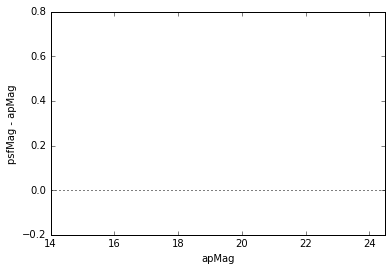

In [17]:
# see how well we did
with afwImageUtils.CalibNoThrow():
    if False:
        apMag = exposure.getCalib().getMagnitude(sources["base_CircularApertureFlux_12_0_flux"])
    else:
        apMag = exposure.getCalib().getMagnitude(sources.getApFlux())

    psfMag = exposure.getCalib().getMagnitude(sources.getPsfFlux())

plt.plot(apMag[good], (psfMag - apMag)[good], 'o')

plt.axhline(0.0, ls=':', color='black')
plt.xlim(14, 24.5)
plt.ylim(-0.2, 0.8)

plt.xlabel("apMag")
plt.ylabel("psfMag - apMag")

plt.show()

In [18]:
if True:
    disp2.mtv(exposure, title='post calib')
else:
    disp2.erase()

In [19]:
with disp2.Buffering():
    for s in sources[good]:
        disp2.dot('+', *s.getCentroid(),
                    ctype=afwDisplay.CYAN if s.get("flags_negative") else afwDisplay.GREEN)

In [20]:
if True:
    radii = algMetadata.get("base_CircularApertureFlux_radii")

    with disp2.Buffering():
        for s in sources[good]:
            for radius in radii:
                disp2.dot('o', *s.getCentroid(), size=radius, ctype=afwDisplay.YELLOW)